# Bone Metastasis Classification using Lightweight LB-FCNN

### Import Libraries

In [1]:
import os
import numpy as np
import pandas as pd
from PIL import Image
from io import StringIO
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, models
from torchvision.utils import make_grid
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from torchstat import stat

C:\Users\Irish\anaconda3\envs\conv_env\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: [WinError 127] The specified procedure could not be found
  warn(f"Failed to load image Python extension: {e}")


### Define Variables & Helper Functions

In [2]:
# Set seed for random number generation to create reproducible results
random_seed = 5
torch.manual_seed(random_seed)

In [3]:
# Transformations to apply to inputs
preprocess = transforms.Compose([
    # Convert PIL Image to tensor and scale to [0, 1] through max normalization
    # (i.e. for every pixel in image, new_pixel_value = pixel/255)
    transforms.ToTensor()
])

In [4]:
# Helper function to get ground truth class of an image
def get_img_labels(img_dir):
    labels = ''
    
    for filename in os.listdir(img_dir):
        # If image has no metastasis
        if (filename[5] == '0'):
            labels += filename + ",0\n"
            
        # If image has metastasis
        else:
            labels += filename + ",1\n"
        
    return labels

### Load Data

In [5]:
data_dir = r"dataset-sample-flat"

In [6]:
# Image dataset
class CustomDataset(Dataset):
    def __init__(self, img_dir, transform):
        self.img_dir = img_dir
        self.img_labels = pd.read_csv(StringIO(get_img_labels(img_dir)), sep=",", header=None)
        self.transform = transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        # Generate image filepath
        filename = self.img_labels.iloc[idx, 0]
        img_path = self.img_dir + "/" + filename
        
        # Read and transform image
        image = Image.open(img_path).convert("L") # TODO: Change to greyscale
        image = self.transform(image)
        
        # Determine ground truth class (metastasis or no metastasis)
        label = self.img_labels.iloc[idx, 1]
        return image, label

In [7]:
# Dataset and dataloader for training data
dataset = CustomDataset(img_dir=data_dir, transform=preprocess)

### Define Model

In [8]:
# Create model with CNN and MLP for classification
class LBFCNN_light(nn.Module):
    # Define layers
    def __init__(self):
        super().__init__()
        self.conv = nn.Conv2d(in_channels = 1, out_channels = 1, kernel_size = 5)
        self.pool = nn.MaxPool2d(kernel_size = 2)
        self.fc1 = nn.Linear(in_features = 1 * 158 * 52, out_features = 200)
        self.fc2 = nn.Linear(in_features = 200, out_features = 100)
        self.fc3 = nn.Linear(in_features = 100, out_features = 2)

    # Apply layers
    def forward(self, x):
        # CNN layers for convoltion
        x = self.pool(F.relu(self.conv(x)))
        x = self.pool(F.relu(self.conv(x)))
        # Flatten all dimensions except batch
        x = torch.flatten(input = x, start_dim = 1)
        # MLP layers for classification
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        # Final activation layer
        x = F.softmax(input = x, dim = 1)
        return x

In [9]:
# Allocate tensors to the device used for computation
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Performing torch operations on {device} device")

Performing torch operations on cpu device


### Train Model

In [10]:
# Model hyperparameters; epochs & batch size from Magboo & Abu
k_folds = 2 # TODO: Change to 10
epochs = 2 # TODO: Change to 100
batch_size = 16

In [11]:
# Evaluation metrics
results_accuracy = []
results_precision = []
results_sensitivity = []
results_specificity = []
results_f1 = []
losses = []

In [12]:
# Define the K-fold Cross Validator
kfold = KFold(n_splits=k_folds, shuffle=True, random_state=random_seed)

In [13]:
# Train model for k folds, with e epochs each
for fold, (train_indices, test_indices) in enumerate(kfold.split(dataset)):
    print('-' * 50)
    print(f'FOLD {fold}/{k_folds}: Training')
    print('-' * 50)
    
    # Sample elements randomly from selected train/test indices
    train_subsampler = torch.utils.data.SubsetRandomSampler(train_indices)
    test_subsampler = torch.utils.data.SubsetRandomSampler(test_indices)
    
    # Get DataLoaders for training and test sets
    trainloader = torch.utils.data.DataLoader(dataset, 
                                              batch_size=batch_size, 
                                              sampler=train_subsampler)
    
    testloader = torch.utils.data.DataLoader(dataset,
                                             batch_size=batch_size, 
                                             sampler=test_subsampler)
    
    losses.append([])
    
    # Instantiate model
    model = LBFCNN_light().to(device)
    
    # Define criterion (function used to compute loss) and optimizer for model
    criterion = nn.CrossEntropyLoss().to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.0001)
    
    # Train for e epochs
    for epoch in range(epochs):
        running_loss = 0
        total_batch_count = 0
        
        for batch_index, batch_data in enumerate(trainloader):
            # Get the inputs; data is a list of [images, labels]
            images, labels = batch_data

            # Forward pass
            predictions = model(images) # Pass input through model.forward()
            loss = criterion(predictions, labels) # Compute loss against ground truth labels

            # Backpropagation
            optimizer.zero_grad() # Reset gradients from previous passes
            loss.backward() # Compute gradients using derivative of loss
            optimizer.step() # Update values using gradients

            running_loss += loss.item() # Add batch loss to current epoch loss
            total_batch_count += 1 # Increment number of finished batches

        running_loss = running_loss / total_batch_count
        losses[fold].append(running_loss)
        print(f"Epoch {epoch}/{epochs-1} Loss: {running_loss}")

    print('-' * 50)
    print(f'FOLD {fold}/{k_folds}: Test Results')
    print('-' * 50)

    # Evaluation for this fold
    true_pos = 0
    true_neg = 0
    false_pos = 0
    false_neg = 0
    total = 0
    
    correct, total = 0, 0
    with torch.no_grad():
        for batch_index, batch_data in enumerate(testloader):
            # Get the inputs; data is a list of [images, labels]
            images, labels = batch_data

            # Forward pass
            predictions = model(images)

            # Set total and correct
            _, predicted = torch.max(input=predictions, dim=1) # Get list of predicted classes
            
            # Get how many classes there were in this batch
            total += labels.size(0)
            
            # Get true positive, true negative, false positive, and false negative counts
            for index in range(len(labels)):
                true_pos = true_pos+1 if (predicted[index] == 1 and labels[index] == 1) else true_pos
                true_neg = true_neg+1 if (predicted[index] == 0 and labels[index] == 0) else true_neg
                false_pos = false_pos+1 if (predicted[index] == 1 and labels[index] == 0) else false_pos
                false_neg = false_neg+1 if (predicted[index] == 0 and labels[index] == 1) else false_neg
    
    print(f"TP: {true_pos}, TN: {true_neg}, FP: {false_pos}, FN: {false_neg}, total: {total}")
    
    # Get evaluation metrics
    # accuracy: (tp + tn) / (p + n)
    accuracy = (true_pos + true_neg)/total if total != 0 else 0
    print(f"Accuracy: {accuracy}")
    results_accuracy.append(accuracy)
    
    # precision tp / (tp + fp)
    precision = true_pos/(true_pos + false_pos) if (true_pos + false_pos) != 0 else 0
    print(f"Precision: {precision}")
    results_precision.append(precision)
    
    # sensitivity: tp / (tp + fn)
    sensitivity = true_pos/(true_pos + false_neg) if (true_pos + false_neg) != 0 else 0
    print(f"Sensitivity: {sensitivity}")
    results_sensitivity.append(sensitivity)
    
    # specificity: tn / (tn + fp)
    specificity = true_neg/(true_neg + false_pos) if (true_neg + false_pos) != 0 else 0
    print(f"Specificity: {specificity}")
    results_specificity.append(specificity)
    
    # f1: 2(precision * recall)/(precision + recall)
    f1 = 2 * (precision * sensitivity)/(precision + sensitivity) if (precision + sensitivity) != 0 else 0
    print(f"F1: {f1}")
    results_f1.append(f1)

--------------------------------------------------
FOLD 0/2: Training
--------------------------------------------------
Epoch 0/1 Loss: 0.693147463457925
Epoch 1/1 Loss: 0.6931472846439907
--------------------------------------------------
FOLD 0/2: Test Results
--------------------------------------------------
TP: 0, TN: 65, FP: 0, FN: 35, total: 100
Accuracy: 0.65
Precision: 0
Sensitivity: 0.0
Specificity: 1.0
F1: 0
--------------------------------------------------
FOLD 1/2: Training
--------------------------------------------------
Epoch 0/1 Loss: 0.6895491225378854
Epoch 1/1 Loss: 0.6872553910527911
--------------------------------------------------
FOLD 1/2: Test Results
--------------------------------------------------
TP: 0, TN: 66, FP: 0, FN: 34, total: 100
Accuracy: 0.66
Precision: 0
Sensitivity: 0.0
Specificity: 1.0
F1: 0


### Save Model

In [14]:
# Print tensor sizes per layer in model
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

Model's state_dict:
conv.weight 	 torch.Size([1, 1, 5, 5])
conv.bias 	 torch.Size([1])
fc1.weight 	 torch.Size([200, 8216])
fc1.bias 	 torch.Size([200])
fc2.weight 	 torch.Size([100, 200])
fc2.bias 	 torch.Size([100])
fc3.weight 	 torch.Size([2, 100])
fc3.bias 	 torch.Size([2])


In [15]:
# Print optimizer's state_dict
print("Optimizer's state_dict:")
for var_name in optimizer.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name])

Optimizer's state_dict:
state 	 {0: {'step': tensor(14.), 'exp_avg': tensor([[[[0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0.]]]]), 'exp_avg_sq': tensor([[[[0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0.]]]])}, 1: {'step': tensor(14.), 'exp_avg': tensor([0.]), 'exp_avg_sq': tensor([0.])}, 2: {'step': tensor(14.), 'exp_avg': tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]), 'exp_avg_sq': tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 

In [16]:
torch.save(model.state_dict(), 'weights/lbfcnn_weights.h5')

### Evaluate Model

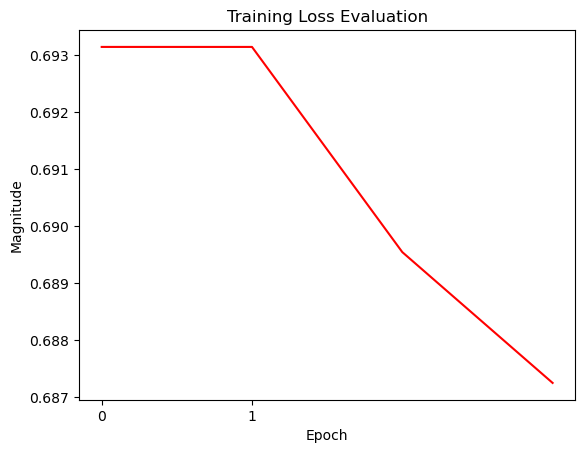

In [17]:
# Plot losses
ax = plt.axes()
flat_losses = [item for fold_losses in losses for item in fold_losses]
plt.plot(flat_losses, color='red')
plt.title('Training Loss Evaluation')
ax.set_xticks([x for x in range(epochs)])
plt.xlabel('Epoch')
plt.ylabel('Magnitude')
plt.show()

In [18]:
# Get performance metrics by calculcating average of metrics across all folds
print("Final Performance Metrics")
print(f"Accuracy: {np.mean(results_accuracy)}")
print(f"Precision: {np.mean(results_precision)}")
print(f"Sensitivity: {np.mean(results_sensitivity)}")
print(f"Specificity: {np.mean(results_specificity)}")
print(f"F1: {np.mean(results_f1)}")

Final Performance Metrics
Accuracy: 0.655
Precision: 0.0
Sensitivity: 0.0
Specificity: 1.0
F1: 0.0


In [19]:
# Get computational complexity
stat(model, (1, 646, 220))

      module name  input shape output shape     params memory(MB)         MAdd        Flops  MemRead(B)  MemWrite(B) duration[%]  MemR+W(B)
0            conv    1 321 108    1 317 104       26.0       0.13  1,648,400.0    857,168.0    138776.0     131872.0      49.82%   270648.0
1            pool    1 317 104    1 158  52        0.0       0.03     24,648.0     32,968.0    131872.0      32864.0       0.00%   164736.0
2             fc1         8216          200  1643400.0       0.00  3,286,200.0  1,643,200.0   6606464.0        800.0      50.18%  6607264.0
3             fc2          200          100    20100.0       0.00     39,900.0     20,000.0     81200.0        400.0       0.00%    81600.0
4             fc3          100            2      202.0       0.00        398.0        200.0      1208.0          8.0       0.00%     1216.0
total                                        1663728.0       0.16  4,999,546.0  2,553,536.0      1208.0          8.0     100.00%  7125464.0
Total params: 1,663,

C:\Users\Irish\anaconda3\envs\conv_env\lib\site-packages\torchstat\reporter.py:63: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(total_df)


### Show Predictions on Sample Images

In [20]:
sample_img_names = ["0000-0-A.tif", "0163-0-P.tif", "0198-0-A.tif"]
sample_img_paths = [(data_dir + "/" + sample_img_names[i]) for i in range(len(sample_img_names))]
sample_classes = [sample_img_names[i][5] for i in range(len(sample_img_names))]
sample_ground_truths = ["No Metastasis" if sample_classes[i] == 0 else "Metastasis" for i in range(len(sample_img_names))]
sample_imgs = [Image.open(img_path).convert('L') for img_path in sample_img_paths]
sample_imgs_show = [Image.open(img_path) for img_path in sample_img_paths]

In [21]:
validation_batch = torch.stack([preprocess(img).to(device) for img in sample_imgs])

In [22]:
sample_preds= model(validation_batch).data.numpy()
sample_preds

array([[0.5193811 , 0.48061895],
       [0.5193811 , 0.48061895],
       [0.5193811 , 0.48061895]], dtype=float32)

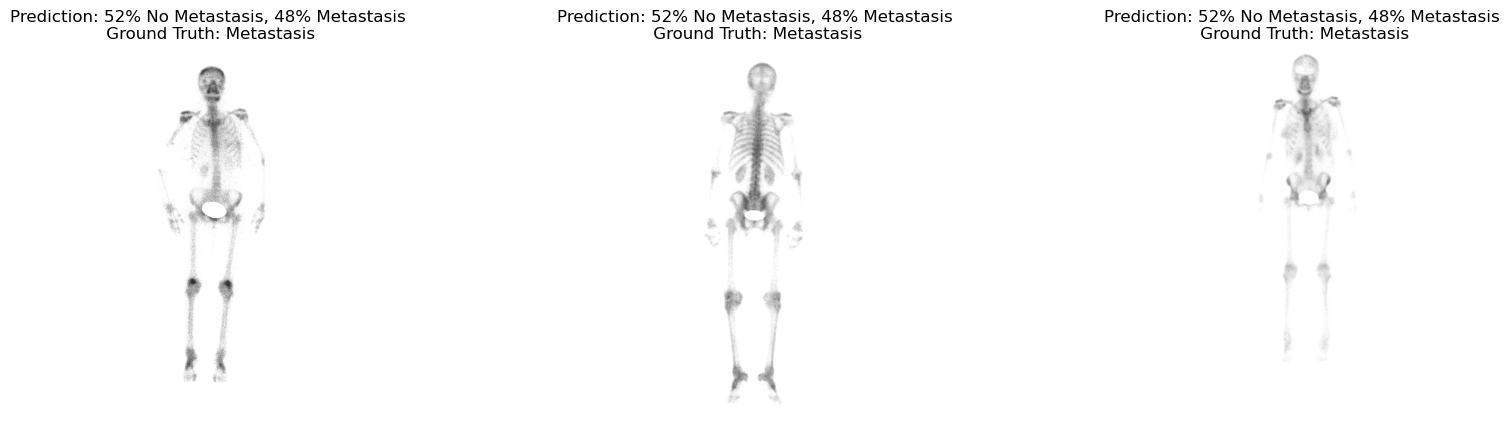

In [23]:
fig, axs = plt.subplots(1, len(sample_imgs_show), figsize=(20, 5))
for i, img in enumerate(sample_imgs_show):
    ax = axs[i]
    ax.axis('off')
    ax.set_title("Prediction: {:.0f}% No Metastasis, {:.0f}% Metastasis\n Ground Truth: {}"
                 .format(100*sample_preds[i,0], 100*sample_preds[i,1], sample_ground_truths[i]))
    ax.imshow(img)